# Demo a Single Simulation Run

In this notebook, we demonstrate a single run of our risk simulation:
- We show the logs of agent actions (e.g. liquidations, arbitrages, peg keeper updates).
- We show a timeseries view of the metrics we collect on agents and the crvusd contracts.
- We plot and analyze results

### Some current limitations
- We are only modeling a single LLAMMA. We are working to incorporate all LLAMMAs to consider hollistic systemic risk.
- We are not considering some key Curve pools yet. For example, we are not explicitly modeling the TriCrypto-ng pools that feed into LLAMMA's oracle.

In [1]:
import pandas as pd

from src.logging import get_logger

logger = get_logger(__name__, "debug")

from src.sim.scenario import Scenario
from src.sim.processing import SingleSimProcessor
from src.plotting.sim import plot_prices
from src.metrics import DEFAULT_METRICS

pd.set_option("display.max_columns", None)
%load_ext autoreload
%autoreload 2

[INFO][19:21:28][src.sim.scenario]-17640: Fetching sim_market from subgraph.
[INFO][19:21:37][src.utils.poolgraph]-17640: Found 20 valid trading cycles of length 3.


Running 168 steps with frequency 1h.


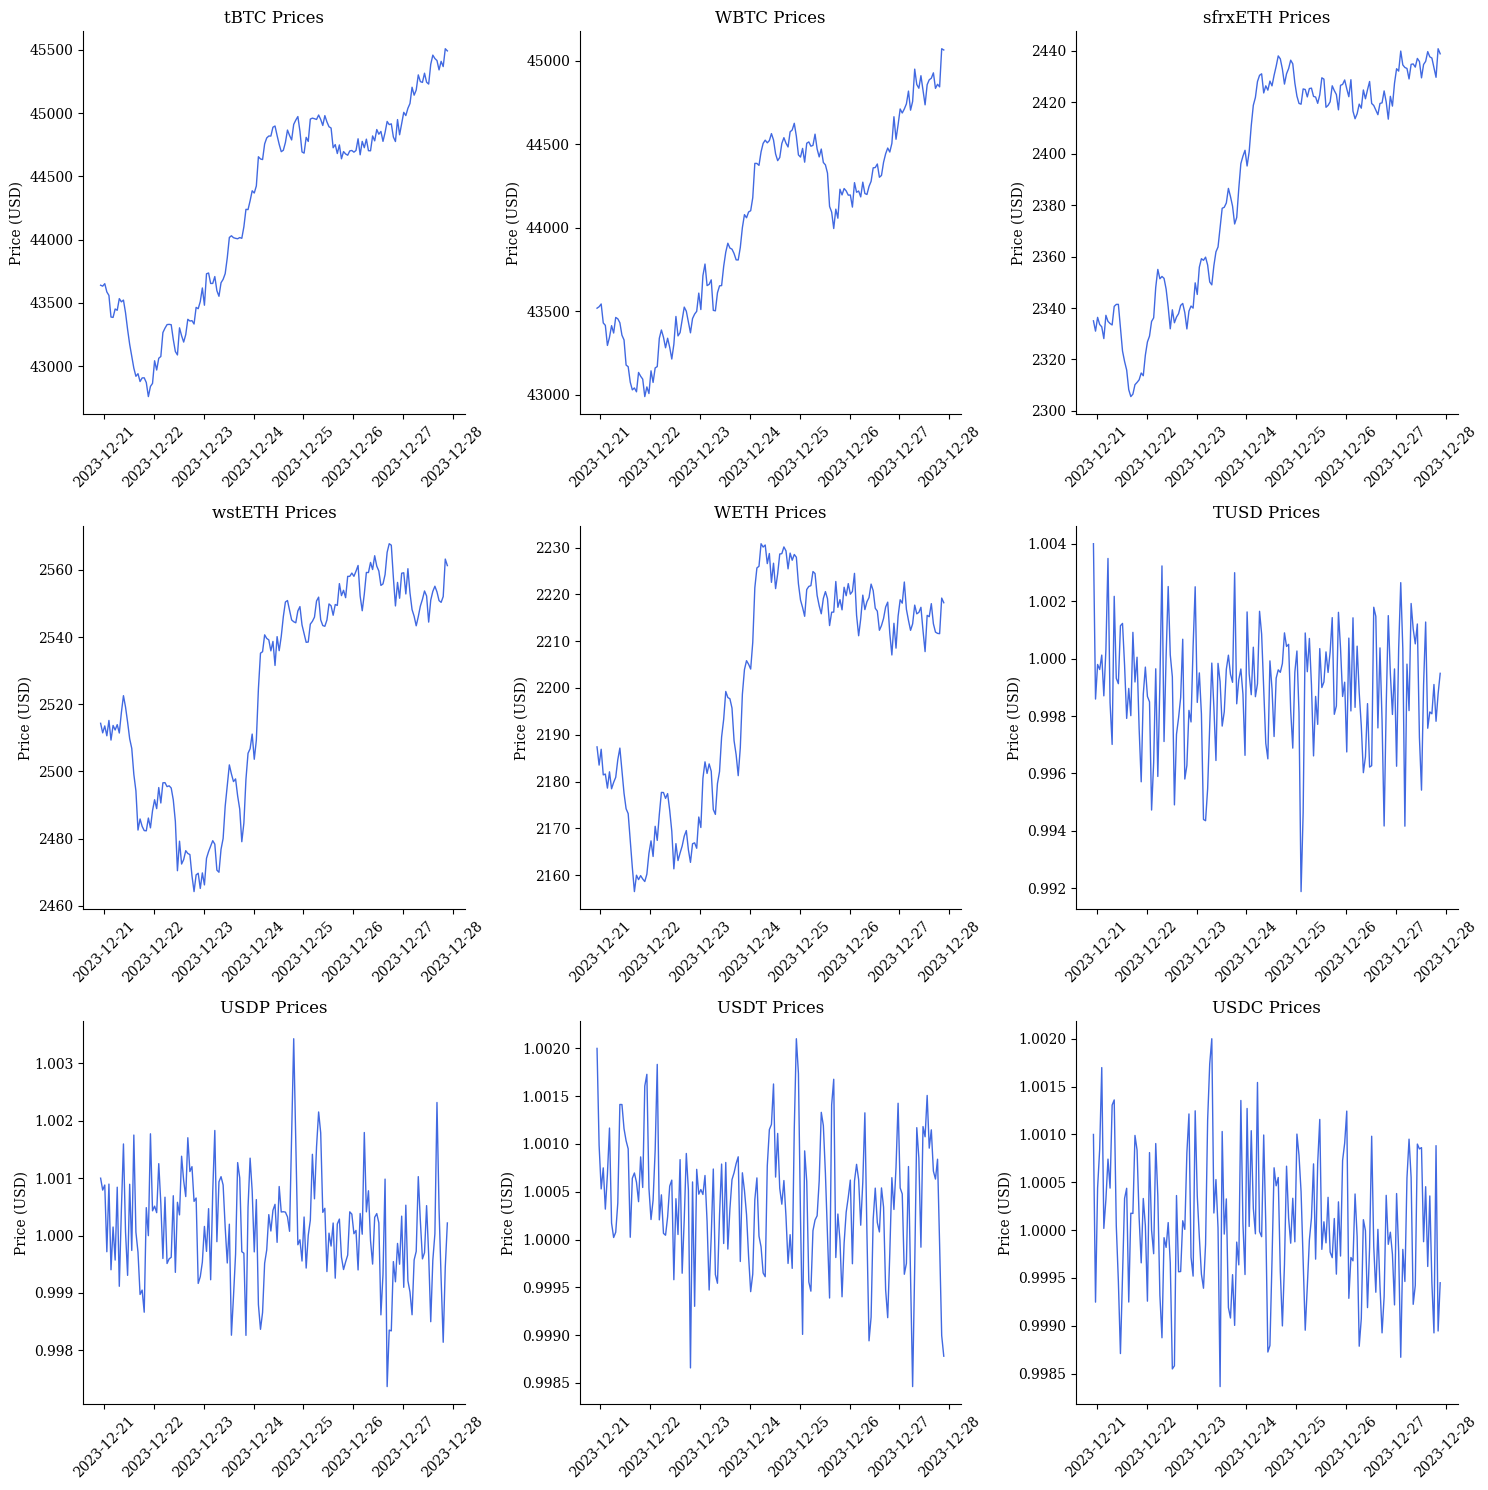

In [11]:
# Generate markets and prices
market_name = "wstETH"
scenario = Scenario("baseline", market_name)
scenario.prepare_for_run()
_ = plot_prices(scenario.pricepaths.prices)
print(
    f"Running {scenario.num_steps} steps with frequency {scenario.pricepaths.config['freq']}."
)

In [12]:
processor = SingleSimProcessor(scenario, DEFAULT_METRICS)
processor.initial_state

{'timestamp': Timestamp('2023-12-20 22:21:34'),
 'arbitrageur_profit': 0,
 'arbitrageur_count': 0,
 'liquidator_profit': 0.0,
 'liquidator_count': 0,
 'keeper_profit': 0.0,
 'keeper_count': 0,
 'borrower_profit': 0.0,
 'borrower_count': 0,
 'liquidityprovider_profit': 0.0,
 'liquidityprovider_count': 0,
 'aggregator_price': 999961310614925797,
 'controller_wstETH_system_health': 5.6935187285521e+17,
 'controller_wstETH_bad_debt': 5409445399420611918691392,
 'controller_wstETH_num_loans': 324,
 'controller_wstETH_total_debt': 35617943562637531152823244,
 'controller_wstETH_users_to_liquidate': 1,
 'llamma_wstETH_price': 2354009457715118097479,
 'llamma_wstETH_oracle_price': 2508918461123961290752,
 'llamma_wstETH_fees_x': 0,
 'llamma_wstETH_fees_y': 0,
 'llamma_wstETH_bal_x': 1207131339598776831574016,
 'llamma_wstETH_bal_y': 23394856791301591455400,
 'pk_crvUSD/TUSD_debt': 73333405378471742998295,
 'pk_crvUSD/TUSD_profit': 0,
 'pk_crvUSD/USDP_debt': 0,
 'pk_crvUSD/USDP_profit': 0,
 'pk

Text(0.5, 1.0, 'wstETH Loan Distribution')

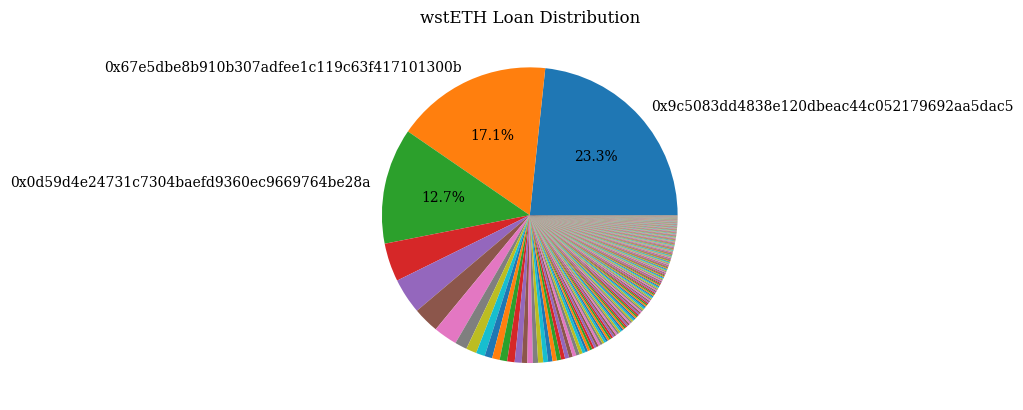

In [13]:
import matplotlib.pyplot as plt


def custom_autopct(pct):
    return "{:.1f}%".format(pct) if pct > 5 else ""


controller = scenario.controller
total_debt = 0
loans = {}
for user, loan in controller.loan.items():
    debt = loan.initial_debt / 1e18
    loans[user] = debt
    total_debt += debt

thresh = 0.05 * total_debt
loans = dict(sorted(loans.items(), key=lambda x: x[1], reverse=True))
labels = [a if loans[a] > thresh else "" for a in loans.keys()]
f, ax = plt.subplots()
pie = ax.pie(loans.values(), labels=labels, autopct=custom_autopct)
ax.set_title(f"{scenario.market_name} Loan Distribution")

### Run the Sim

In [14]:
for sample in scenario.pricepaths:
    scenario.prepare_for_trades(sample)  # update prices/timestamps
    scenario.perform_actions(sample)  # arbitrage, liquidate, update
    processor.update(sample.timestamp, inplace=True)  # collect metrics

In [15]:
df = processor.results
df.to_csv("../data/results.csv")
df.head()

,timestamp,arbitrageur_profit,arbitrageur_count,liquidator_profit,liquidator_count,keeper_profit,keeper_count,borrower_profit,borrower_count,liquidityprovider_profit,liquidityprovider_count,aggregator_price,controller_wstETH_system_health,controller_wstETH_bad_debt,controller_wstETH_num_loans,controller_wstETH_total_debt,controller_wstETH_users_to_liquidate,llamma_wstETH_price,llamma_wstETH_oracle_price,llamma_wstETH_fees_x,llamma_wstETH_fees_y,llamma_wstETH_bal_x,llamma_wstETH_bal_y,pk_crvUSD/TUSD_debt,pk_crvUSD/TUSD_profit,pk_crvUSD/USDP_debt,pk_crvUSD/USDP_profit,pk_crvUSD/USDC_debt,pk_crvUSD/USDC_profit,pk_crvUSD/USDT_debt,pk_crvUSD/USDT_profit,stablecoin_total_supply,stableswap_crvUSD_TUSD_price,stableswap_crvUSD_TUSD_ma_price,stableswap_crvUSD_TUSD_lp_supply,stableswap_crvUSD_TUSD_virtual_price,stableswap_crvUSD_TUSD_TUSD_bal,stableswap_crvUSD_TUSD_crvUSD_bal,stableswap_crvUSD_USDP_price,stableswap_crvUSD_USDP_ma_price,stableswap_crvUSD_USDP_lp_supply,stableswap_crvUSD_USDP_virtual_price,stableswap_crvUSD_USDP_USDP_bal,stableswap_crvUSD_USDP_crvUSD_bal,stableswap_crvUSD_USDC_price,stableswap_crvUSD_USDC_ma_price,stableswap_crvUSD_USDC_lp_supply,stableswap_crvUSD_USDC_virtual_price,stableswap_crvUSD_USDC_USDC_bal,stableswap_crvUSD_USDC_crvUSD_bal,stableswap_crvUSD_USDT_price,stableswap_crvUSD_USDT_ma_price,stableswap_crvUSD_USDT_lp_supply,stableswap_crvUSD_USDT_virtual_price,stableswap_crvUSD_USDT_USDT_bal,stableswap_crvUSD_USDT_crvUSD_bal
0,2023-12-20 22:21:34,57513.768413,6,11804.855245,2,0.000000e+00,0,0.0,0,0.0,0,999961310614925797,5.709803e+17,5332111910119806894210112,322,35537783926974716260681998,1,2492052530110543972518,2508918461123961290752,13698,0,3490396191585725316704151,22424196392559469882063,73333405378471742998295,0,0,0.0,0,0,539289715013448093244855,0,236141921468571455338072312,997934384311203654,998960294461773050,4479612839066515417335527,1000003669284475278,1389387597691080671259398,3090994974125753412584376,1000193435478736206,999547725292603031,4142004935874783108777492,1000003970576266270,2170893492584894593508067,1971137526099634989507366,1000617889910329249,999816321589534618,36946074312894024449963789,1000004847532611525,21208515337079,15738564329423268683427958,999958820783489390,1000310994460611072,27894904498848042168293720,1000002182465869412,13803637915728,14091330424282268476370788
1,2023-12-20 23:21:34,59352.091205,9,11804.855245,2,8.321298e+19,1,0.0,0,0.0,0,1000309946520432685,5.723771e+17,5332111910119806894210112,322,35538312121942478252065174,1,2499434880562562027426,2511430760241873225987,13698,0,3490396191585725316704151,22424196392559469882063,73333405378471742998295,0,0,0.0,1346839455880199612731059,332851903301708449975,539289715013448093244855,0,238176536429005895497922506,1001114741586293001,1000626477160184729,4479612839066515417335527,1000019334148788780,2791822994458036332948230,1688165276737466066416108,999800304166172138,999796340099694388,4142004935874783108777492,1000006421117645361,1967921327709281577112639,2174120474359660647763293,1000584604229835256,1000763517963167531,38293321752343067486723492,1000006742727558852,21840854692862,16453496882877787233602293,999411575146690077,999619337346426300,27894904498848042168293720,1000005465343153956,11972664192310,15922962436456682977965055
2,2023-12-21 00:21:34,59802.706754,10,11804.855245,2,9.213338e+19,2,0.0,0,0.0,0,1000106658043002589,5.735391e+17,5332111910119806894210112,322,35538840199326833178915831,1,2505626425517132323401,2513538097789073069565,13698,0,3490396191585725316704151,22424196392559469882063,73333405378471742998295,0,0,0.0,1896835797520525264852770,370852751712450849382,539289715013448093244855,0,239494970693429480003711654,1001114741586293001,1001107114234938482,4479612839066515417335527,1000019334148788780,2791822994458036332948230,1688165276737466066416108,999800304166172138,999800231857210819,4142004935874783108777492,1000006421117645361,1967921327709281577112639,2174120474359660647763293,100022757281

<Axes: >

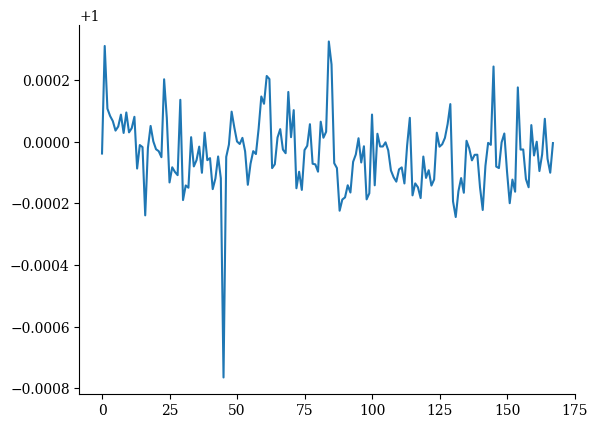

In [16]:
(df["aggregator_price"] / 1e18).plot()

<Axes: >

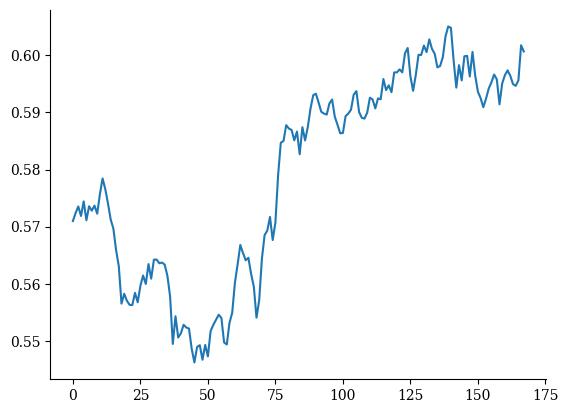

In [17]:
(df[f"controller_{market_name}_system_health"] / 1e18).plot()

<Axes: >

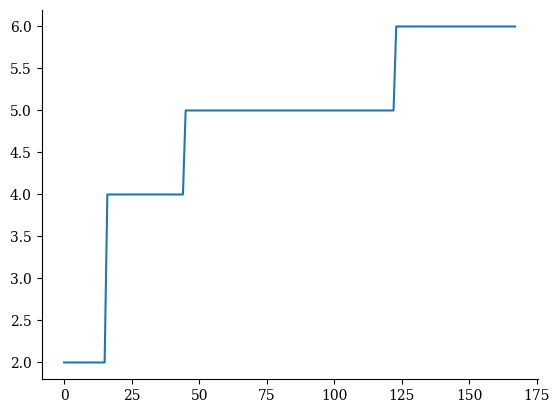

In [18]:
df["liquidator_count"].plot()

Notice that the above is a standard result from risk simulations: frequent, small liquidations actually *improve* the health of the system! 

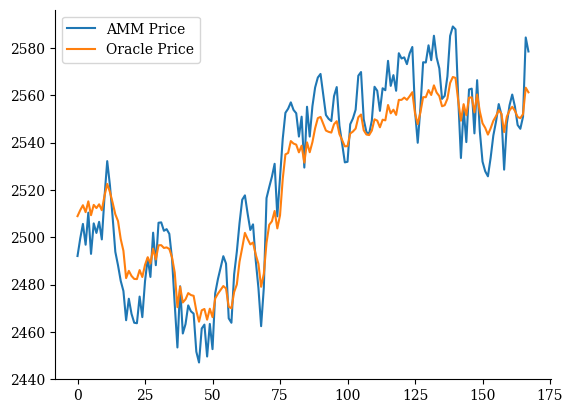

In [19]:
(df[f"llamma_{market_name}_price"] / 1e18).plot(label="AMM Price")
(df[f"llamma_{market_name}_oracle_price"] / 1e18).plot(
    label="Oracle Price"
)  # = spot price for now
plt.legend()
# scenario.pricepaths.prices[SYMBOL_TO_ADDRESS["WETH"]].reset_index(drop=True).plot()

Text(0.5, 1.0, 'Profits sans t0')

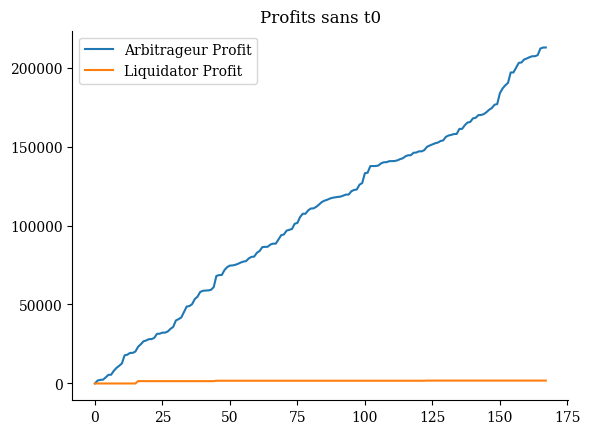

In [20]:
(df["arbitrageur_profit"] - df["arbitrageur_profit"].iloc[0]).plot(
    label="Arbitrageur Profit"
)
(df["liquidator_profit"] - df["liquidator_profit"].iloc[0]).plot(
    label="Liquidator Profit"
)
plt.legend()
plt.title("Profits sans t0")

<Axes: >

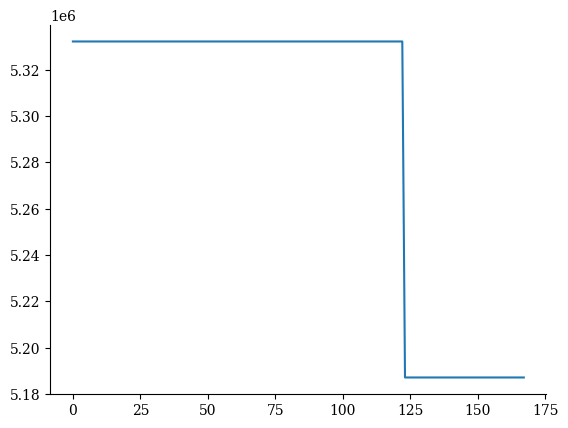

In [21]:
(df[f"controller_{market_name}_bad_debt"] / 1e18).plot()

(1.0, 1.0005)

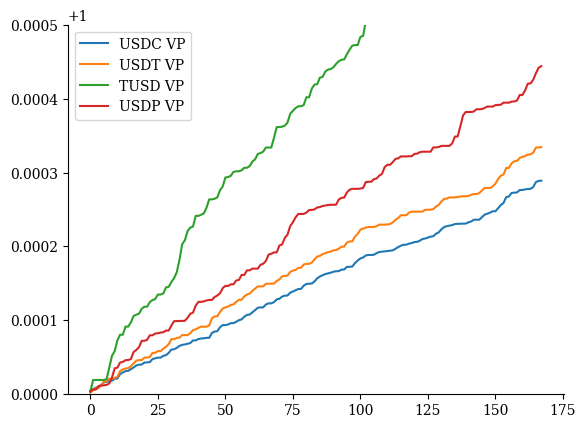

In [22]:
(df["stableswap_crvUSD_USDC_virtual_price"] / 1e18).plot(label="USDC VP")
(df["stableswap_crvUSD_USDT_virtual_price"] / 1e18).plot(label="USDT VP")
(df["stableswap_crvUSD_TUSD_virtual_price"] / 1e18).plot(label="TUSD VP")
(df["stableswap_crvUSD_USDP_virtual_price"] / 1e18).plot(label="USDP VP")
plt.legend()
plt.ylim(1, 1.0005)